# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [1]:
import pandas as pd
import numpy as np
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import os

## Prepare tables

In [2]:
cancer_types = [
    "brca",
#     "colon",
#     "hnscc",
#     "lscc",
#     "luad",
#     "ovarian"
]

In [3]:
def prepare_plot_table(cancer_type):
    
    # Get the followup data
    fp = pd.read_csv(
        os.path.join("..", cancer_type, f"{str.upper(cancer_type)}_survival.txt.gz"), 
        sep="\t"
    ).\
    set_index("sample")
    
    vital_status_col = "OS" # Overall survival
    time_col = "OS.time"
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, time_col]].\
    rename(columns={
        vital_status_col: "death",
        time_col: "days_to_last_contact_or_death"
    })
    
    # Combine completely duplicated rows
    fp = fp.reset_index(drop=False) # So that the index is counted in identifying duplicates
    fp = fp[~fp.duplicated(keep="first")]
    fp = fp.set_index("sample")
    
    # That should have taken care of all duplicates. Yay curated data!
    assert fp.index.duplicated().sum() == 0
    
    # Drop any rows with NaNs
    fp = fp.dropna(axis="index", how="any")
    
    # Fill vals
#     fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the CNV event table
    event = pd.read_csv(f"{cancer_type}_has_event.tsv", sep="\t", index_col=0).\
    rename(columns={
        "gain_event": "8q_gain",
        "loss_event": "8p_loss"
    })
    
    event = event.assign(
        both=event["8p_loss"] & event["8q_gain"],
        neither=~(event["8p_loss"] | event["8q_gain"])
    )
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Check
    assert joined.index.duplicated().sum() == 0
    
    return joined

### Data example

The cell below shows the format we need our data in for the survival analysis. You need three columns:
- Event column (whether they have passed away): Boolean
- Duration column (days until death or last contact): Numeric
- Covariate column (whether each patient had the event): Boolean

In [4]:
prepare_plot_table("brca").head()

,death,days_to_last_contact_or_death,8q_gain,8p_loss,both,neither
TCGA-3C-AAAU-01,0,4047.0,True,False,False,False
TCGA-3C-AALI-01,0,4005.0,True,False,False,False
TCGA-3C-AALJ-01,0,1474.0,True,True,True,False
TCGA-3C-AALK-01,0,1448.0,False,False,False,True
TCGA-4H-AAAK-01,0,348.0,False,True,False,False


## Plot individual variables

In [5]:
def plot_single_var_survival(cancer_type, df, cnv_col):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(f"{cancer_type} - {cnv_col}")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[cnv_col].sum()
    no_event_count = df[cnv_col].size - has_event_count
    
    plot_title = f"{cancer_type} survival: {cnv_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

brca - 8p_loss


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.60
         time fit was run = 2020-11-05 23:16:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.50       1.65       0.17             0.17             0.83                 1.18                 2.30

             z      p   -log2(p)
covariate                       
8p_loss   2.93 <0.005       8.22
---
Concordance = 0.56
Partial AIC = 1663.19
log-likelihood ratio test = 8.88 on 1 df
-log2(p) of ll-ratio test = 8.44

brca - 8q_gain


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -834.32
         time fit was run = 2020-11-05 23:16:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8q_gain     0.20       1.22       0.16            -0.12             0.52                 0.88                 1.68

             z    p   -log2(p)
covariate                     
8q_gain   1.20 0.23       2.13
---
Concordance = 0.54
Partial AIC = 1670.64
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.11

brca - both


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -833.07
         time fit was run = 2020-11-05 23:16:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
both        0.34       1.40       0.17             0.01             0.67                 1.01                 1.95

             z    p   -log2(p)
covariate                     
both      2.02 0.04       4.54
---
Concordance = 0.54
Partial AIC = 1668.13
log-likelihood ratio test = 3.94 on 1 df
-log2(p) of ll-ratio test = 4.41

brca - neither


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -831.87
         time fit was run = 2020-11-05 23:16:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
neither    -0.48       0.62       0.20            -0.86            -0.09                 0.42                 0.91

              z    p   -log2(p)
covariate                      
neither   -2.42 0.02       6.00
---
Concordance = 0.55
Partial AIC = 1665.75
log-likelihood ratio test = 6.32 on 1 df
-log2(p) of ll-ratio test = 6.39

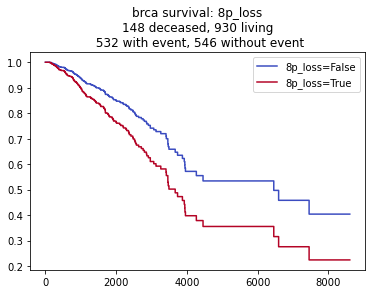

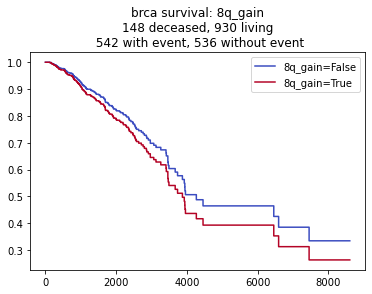

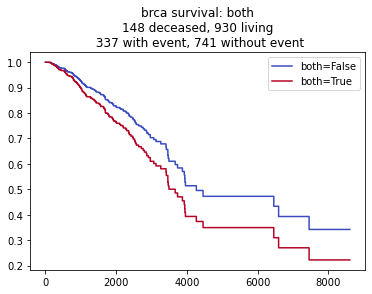

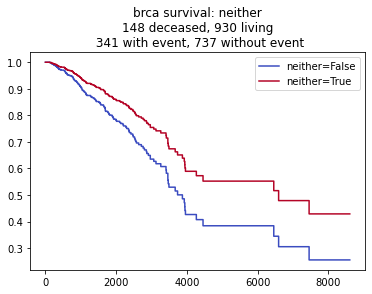

In [6]:
for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    for cnv_col in ["8p_loss", "8q_gain", "both", "neither"]:
        sel_df = df[["death", "days_to_last_contact_or_death", cnv_col]]
        plot_single_var_survival(cancer_type, sel_df, cnv_col)

## Plot multiple variables

In [7]:
def plot_multi_var_survival(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(cancer_type)
    cph.print_summary()
#     print(lifelines.statistics.proportional_hazard_test(cph, df))
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_8p_loss = df["8p_loss"].sum()
    no_8p_loss = df["8p_loss"].size - has_8p_loss
    
    has_8q_gain = df["8q_gain"].sum()
    no_8q_gain = df["8q_gain"].size - has_8q_gain
    
    plot_title = f"{cancer_type} survival: Chromosome 8\n{deceased_count} deceased, {living_count} living" +\
        f"\n{has_8p_loss} with 8p_loss, {no_8p_loss} without" +\
        f"\n{has_8q_gain} with 8q_gain, {no_8q_gain} without"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

brca


<lifelines.CoxPHFitter: fitted with 1078 total observations, 930 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1078
number of events observed = 148
   partial log-likelihood = -830.52
         time fit was run = 2020-11-05 23:16:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.48       1.62       0.18             0.13             0.83                 1.14                 2.30
8q_gain     0.07       1.07       0.17            -0.27             0.40                 0.77                 1.50

             z    p   -log2(p)
covariate                     
8p_loss   2.71 0.01       7.19
8q_gain   0.40 0.69       0.53
---
Concordance = 0.57
Partial AIC = 1665.04
log-likelihood ratio test = 9.04 on 2 df
-log2(p) of ll-ratio test = 6.52

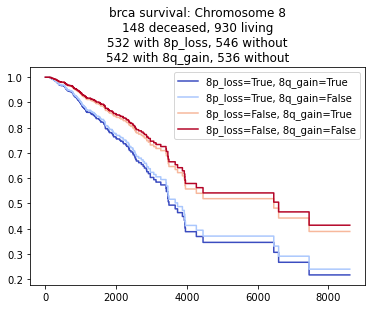

In [8]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    plot_multi_var_survival(cancer_type, df, cnv_cols)

## Plot confidence intervals

In [9]:
def plot_cis(cancer_type, df):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot(ax=plt.axes(label=cancer_type))

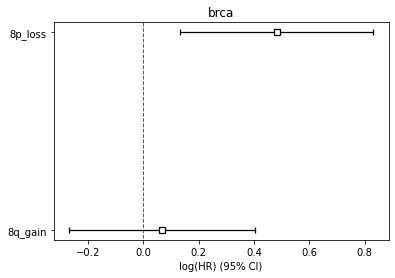

In [10]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type in cancer_types:
    df = prepare_plot_table(cancer_type)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    ax = plot_cis(cancer_type, df)
    ax.set_title(cancer_type)
    plt.show()